In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, ttest_ind, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import env
import acquire
import prep
import split_scale
import model

Data Dictionary located in README.md 

# Plan
- As a junior data scientist, an email requesting the following is recieved?:
    1. Predict the values of single unit properties that a tax district assesses using property data from whos last transaction was during the "hot months" (in terms of real estate demand) of May and June 2017.
    
    2. A few problems exist:    
    __a:__ the current data which gave the location of each property has been lost. We need to know what county each property is located in. So we will have to find a way to acquire this data.
    
    3. The Zillow Data Science team would also like to know the distribution of tax rates for each county but specified this is not part of the __MVP__
        - since the data already has the tax amounts and tax value of the home it should be easy to create a new notebook with this information. 
        __We cannot use this information in our model__

# Deliverables
1. Create a report in the form of slides and present it verbally.
2. Create a github repository containing all my work, which should consist of the following:
    - at least 1 jupyter notebook that walks throuh the pipeline
    - ensure all questions are being answered 
    - add all the `.py` files so our work can be reproduced, knowing that for this to be reporduced by someone else they would have to have their own `env.py` so they can access the SQL  Zillow database

# Aquire  

> Our first iteration will be to use a SQL query to pull data into a jupyter notebook and create a dataframe. Using the following features: square feet of the home, number of bedrooms, number of bathrooms to estimate value of __taxvaslueddollarcnt__. This will be our __MVP(minimally viable product)__

## An MVP is information that is collected and validated with the least effort. The primary benefit of an MVP is to satisfy the request of the Zillow team with just the features they have requested. 

In [2]:
# Here is the SQL query used
query = """ SELECT
    prop.parcelid,
    bathroomcnt AS bathrooms,
    bedroomcnt AS bedrooms,
    calculatedfinishedsquarefeet AS square_feet,
    fips AS fips_number,
    ptype.propertylandusetypeid,
    ptype.propertylandusedesc,
    taxvaluedollarcnt AS home_value,
    taxamount AS tax_amount
    FROM properties_2017 AS prop
        JOIN
        predictions_2017 AS pred
        ON prop.parcelid = pred.parcelid
        JOIN
        propertylandusetype AS ptype
        ON prop.propertylandusetypeid = ptype.propertylandusetypeid

    WHERE transactiondate
    BETWEEN '2017-05-01' AND '2017-06-30' AND propertylandusedesc = ('Single Family Residential')"""

# pull clean data from previous notebook

df = acquire.get_zillow_data_from_sql()

## Pull data into jupyter notebook and create a Pandas DataFrame
  

In [3]:
df.head()

,parcelid,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
0,11289917,2.0,3.0,1458.0,6037.0,261,Single Family Residential,136104.0,2319.90
1,11705026,1.0,2.0,1421.0,6037.0,261,Single Family Residential,35606.0,543.69
2,14269464,3.0,4.0,2541.0,6059.0,261,Single Family Residential,880456.0,9819.72
3,11389003,2.0,3.0,1650.0,6037.0,261,Single Family Residential,614000.0,7673.19
4,11967869,1.0,2.0,693.0,6037.0,261,Single Family Residential,274237.0,3267.47


# Prepare Date
    

## Dive inte the data

In [4]:
df.head()

,parcelid,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
0,11289917,2.0,3.0,1458.0,6037.0,261,Single Family Residential,136104.0,2319.90
1,11705026,1.0,2.0,1421.0,6037.0,261,Single Family Residential,35606.0,543.69
2,14269464,3.0,4.0,2541.0,6059.0,261,Single Family Residential,880456.0,9819.72
3,11389003,2.0,3.0,1650.0,6037.0,261,Single Family Residential,614000.0,7673.19
4,11967869,1.0,2.0,693.0,6037.0,261,Single Family Residential,274237.0,3267.47


In [5]:
df.dtypes

parcelid                   int64
bathrooms                float64
bedrooms                 float64
square_feet              float64
fips_number              float64
propertylandusetypeid      int64
propertylandusedesc       object
home_value               float64
tax_amount               float64
dtype: object

In [101]:
df.unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [6]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'square_feet', 'fips_number',
       'propertylandusetypeid', 'propertylandusedesc', 'home_value',
       'tax_amount'],
      dtype='object')

In [7]:
df.shape

(15036, 9)

In [8]:
print(f'My df has {df.shape[0]} rows and {df.shape[1]} columns.')

My df has 15036 rows and 9 columns.


## Prep the data
  - df.isnull().sum()
  - create a prep.py file to use in cleaning the data
  - use function `clean_data` from `prep.py` to drop nulls
  - I chose to set the index to parcel id because each property has a unqiue number
  - plot the distributions of the independent variables
      - Independent variables are controlled inputs and we will use these types of variables to study the effect they have on the dependent variable

In [9]:
df.isnull().sum()

parcelid                  0
bathrooms                 0
bedrooms                  0
square_feet              24
fips_number               0
propertylandusetypeid     0
propertylandusedesc       0
home_value                0
tax_amount                1
dtype: int64

__It is important to use different variables when changing the dataframe to ensure you are using the correct data__

In [10]:
df_clean = prep.clean_data(df)
## verify nulls are gone
df_clean.isnull().sum()

parcelid                 0
bathrooms                0
bedrooms                 0
square_feet              0
fips_number              0
propertylandusetypeid    0
propertylandusedesc      0
home_value               0
tax_amount               0
dtype: int64

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 0 to 15035
Data columns (total 9 columns):
parcelid                 15011 non-null int64
bathrooms                15011 non-null float64
bedrooms                 15011 non-null float64
square_feet              15011 non-null float64
fips_number              15011 non-null float64
propertylandusetypeid    15011 non-null int64
propertylandusedesc      15011 non-null object
home_value               15011 non-null float64
tax_amount               15011 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB


In [12]:
# we need to change some data types and we also need to set an index id sp for the
# writing I am changing df_clean back to the variable name df
df = df_clean .set_index(['parcelid'])

# changing data types

df = df.astype({'propertylandusedesc': 'category',
               'fips_number': 'int'})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 11289917 to 11464823
Data columns (total 8 columns):
bathrooms                15011 non-null float64
bedrooms                 15011 non-null float64
square_feet              15011 non-null float64
fips_number              15011 non-null int64
propertylandusetypeid    15011 non-null int64
propertylandusedesc      15011 non-null category
home_value               15011 non-null float64
tax_amount               15011 non-null float64
dtypes: category(1), float64(5), int64(2)
memory usage: 952.9 KB


In [13]:
# add the county for each property based off the fips_number which came from o
# utside the dataframe. This tells what county each property is located in
df['county_name'] = df.fips_number.map({6037: 'Los Angeles', 
                                        6059: 'Orange',
                                        6111: 'Ventura'
                                       })

In [14]:
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name
parcelid,,,,,,,,,
11289917,2.0,3.0,1458.0,6037,261,Single Family Residential,136104.0,2319.9,Los Angeles
11705026,1.0,2.0,1421.0,6037,261,Single Family Residential,35606.0,543.7,Los Angeles
14269464,3.0,4.0,2541.0,6059,261,Single Family Residential,880456.0,9819.7,Orange
11389003,2.0,3.0,1650.0,6037,261,Single Family Residential,614000.0,7673.2,Los Angeles
11967869,1.0,2.0,693.0,6037,261,Single Family Residential,274237.0,3267.5,Los Angeles


In [15]:
# need to drop some columns 
df = df.drop(columns=['fips_number', 'propertylandusetypeid', 'propertylandusedesc',
                 'tax_amount', 'county_name'])

# Data Explore & Preprocess

1. Visualize Attributes and interactions
2. Anlyze: using statsmodels, numpy, scipy, scikit-learn
3. __Possible Deliverable Product__
    - report of analysis
    - presentation slide
4. Feature engineering
    - Zillow has chosen the features for us:
        - square feet of home
        - number of bedrooms
        - number of bathrooms
5. Summarize our takaways and conclusions

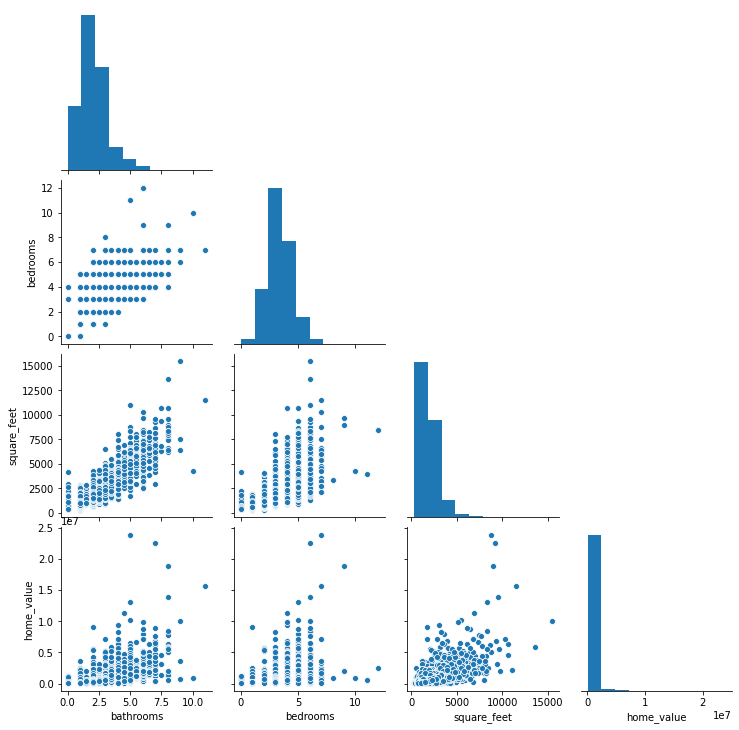

In [16]:
sns.pairplot(df, corner=True)

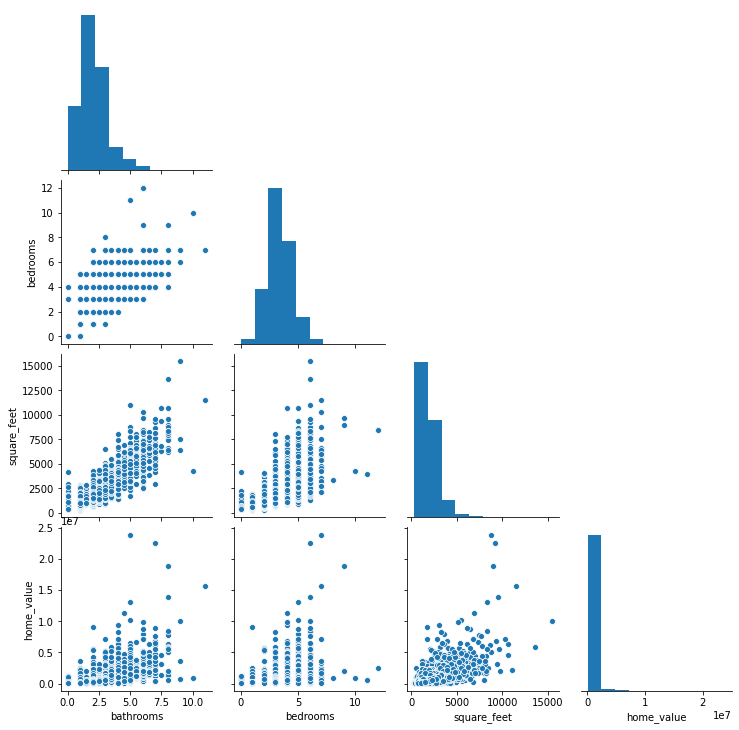

In [17]:
sns.pairplot(df, corner=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2652f190>,
      dtype=object)

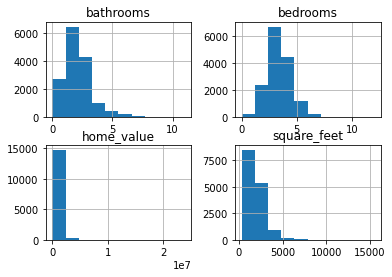

In [18]:
df.hist()

In [19]:
df.corr()

,bathrooms,bedrooms,square_feet,home_value
bathrooms,1.0,0.6,0.9,0.5
bedrooms,0.6,1.0,0.6,0.3
square_feet,0.9,0.6,1.0,0.6
home_value,0.5,0.3,0.6,1.0


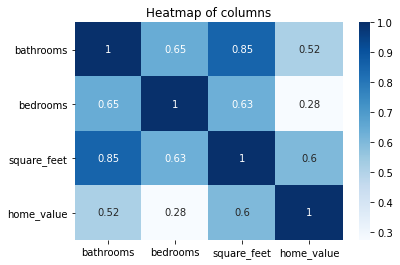

In [20]:
# plot out the correlations w/ a heatmap to get visual insight
plt.title("Heatmap of columns")
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.show()

## What can we see from this heatmap

- our dependent variable is home_value and there is a correlation between `bathrooms`, `bedrooms`, and `square_feet`
- the feature with the highest coorelation is `square_feet`

In [21]:
import sklearn.model_selection

# split into train and test
train, test = sklearn.model_selection.train_test_split(df, train_size=.8, random_state=123)

In [22]:
predictions = pd.DataFrame({'actual' : train.home_value })

In [23]:
predictions.head()

,actual
parcelid,
13851543,453460.0
12543841,245830.0
11064559,52341.0
13038910,118128.0
14056193,774974.0


In [24]:
# Model 1
X = train[['bathrooms']]
y = train.home_value

lm_1 = sklearn.linear_model.LinearRegression()
lm_1.fit(X, y)
predictions['bathrooms'] = lm_1.predict(X)

In [25]:
lm_1.coef_, lm_1.intercept_

(array([371637.761028]), -320348.49553889583)

In [26]:
predictions.head()

,actual,bathrooms
parcelid,,
13851543,453460.0,422927.0
12543841,245830.0,422927.0
11064559,52341.0,422927.0
13038910,118128.0,422927.0
14056193,774974.0,608745.9


In [27]:
X = train[['bedrooms']]
y = train.home_value

lm_2 = sklearn.linear_model.LinearRegression()
lm_2.fit(X, y)
predictions['bedrooms'] = lm_2.predict(X)

In [28]:
lm_2.coef_, lm_2.intercept_

(array([212584.14741087]), -159256.6119310693)

In [29]:
predictions.head()

,actual,bathrooms,bedrooms
parcelid,,,
13851543,453460.0,422927.0,478495.8
12543841,245830.0,422927.0,265911.7
11064559,52341.0,422927.0,478495.8
13038910,118128.0,422927.0,691080.0
14056193,774974.0,608745.9,691080.0


In [30]:
X = train[['square_feet']]
y = train.home_value

lm_3 = sklearn.linear_model.LinearRegression()
lm_3.fit(X, y)
predictions['square_feeet'] = lm_3.predict(X)

In [31]:
lm_3.coef_, lm_3.intercept_

(array([441.26731949]), -314735.2992343814)

In [32]:
predictions.head()

,actual,bathrooms,bedrooms,square_feeet
parcelid,,,,
13851543,453460.0,422927.0,478495.8,243026.6
12543841,245830.0,422927.0,265911.7,389527.3
11064559,52341.0,422927.0,478495.8,302597.7
13038910,118128.0,422927.0,691080.0,653405.2
14056193,774974.0,608745.9,691080.0,805201.2


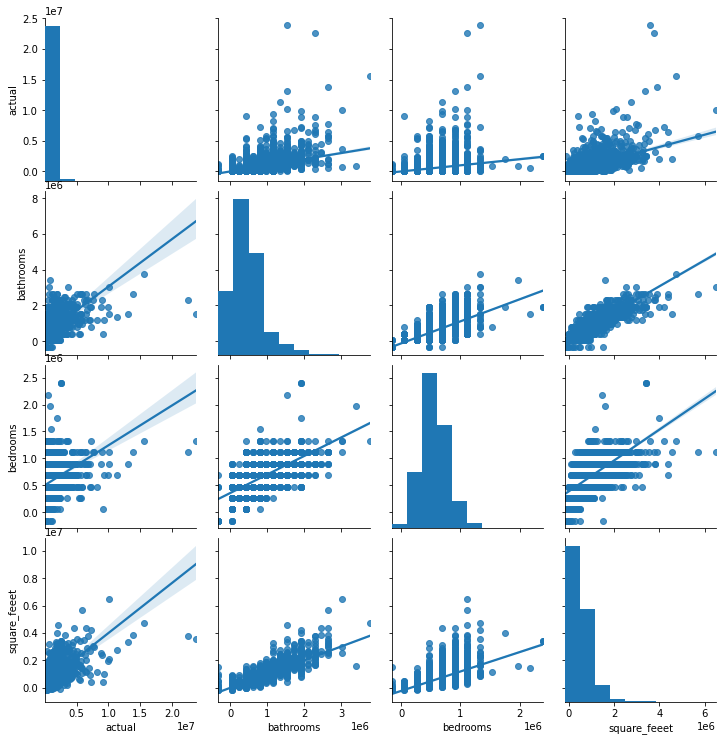

In [33]:
sns.pairplot(predictions, kind = 'reg')

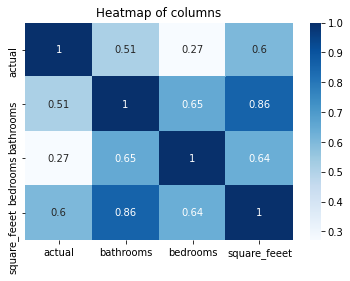

In [34]:
plt.title("Heatmap of columns")
sns.heatmap(predictions.corr(), cmap='Blues', annot=True)
plt.show()

In [35]:
# Define X and y variables
X = df[['bathrooms', 'bedrooms', 'square_feet']]
y = df[['home_value']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=123)

In [36]:
X_train.head()

,bathrooms,bedrooms,square_feet
parcelid,,,
11713180,3.0,2.0,1736.0
10774370,3.0,3.0,1565.0
12279758,2.0,3.0,1334.0
14476387,2.0,2.0,1503.0
10719724,2.0,3.0,1372.0


In [37]:
results = smf.ols('home_value ~ bedrooms + bathrooms + square_feet', data=df).fit()

In [38]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             home_value   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     3102.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:01:59   Log-Likelihood:            -2.2035e+05
No. Observations:               15011   AIC:                         4.407e+05
Df Residuals:                   15007   BIC:                         4.407e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.902e+04   1.73e+04     -1.674      

In [39]:
df.head()

,bathrooms,bedrooms,square_feet,home_value
parcelid,,,,
11289917,2.0,3.0,1458.0,136104.0
11705026,1.0,2.0,1421.0,35606.0
14269464,3.0,4.0,2541.0,880456.0
11389003,2.0,3.0,1650.0,614000.0
11967869,1.0,2.0,693.0,274237.0


In [40]:
# Create Model
ols_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet', data=df).fit()

# Predict Model
ols_yhat = ols_model.predict(X_train)

In [41]:
# Create a DataFrame for evaluating my model(s) and Baseline Value
ols_eval = y_train.copy()
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)

In [42]:
# Add Baseline Column
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)

In [43]:
# Add Baseline
ols_eval['baseline_yhat'] = ols_eval['actual'].mean()

In [44]:
# Add OLS predictions columns
ols_eval['ols_yhat'] = ols_model.predict(X_train)

In [45]:
# Calculate and Add residuals colomns for plotting
ols_eval['residuals'] = ols_eval.ols_yhat - ols_eval.actual

In [46]:
# Compute the RMSE for our ols Model and Baseline using our created dataframe
baseline_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat))

ols_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat))
print(baseline_RMSE)
print(ols_RMSE)
print(f'My model has value: {ols_RMSE < baseline_RMSE}')

752417.9494731158
589415.467621281
My model has value: True


In [47]:
# Compute the RMSE for the model we created
ols_r2 = round(ols_model.rsquared,3)

ols_p_value = ols_model.f_pvalue

print(f'My R-squared score is significant: {ols_p_value < .05}')

My R-squared score is significant: True


In [48]:
ols_eval.head()

,actual,baseline_yhat,ols_yhat,residuals
parcelid,,,,
11713180,446597.0,547467.9,677810.2,231213.2
10774370,364898.0,547467.9,448062.6,83164.6
12279758,254856.0,547467.9,279033.4,24177.4
14476387,228954.0,547467.9,507829.1,278875.1
10719724,62074.0,547467.9,297120.9,235046.9


In [49]:
print(baseline_RMSE), print(ols_RMSE)

752417.9494731158
589415.467621281


(None, None)

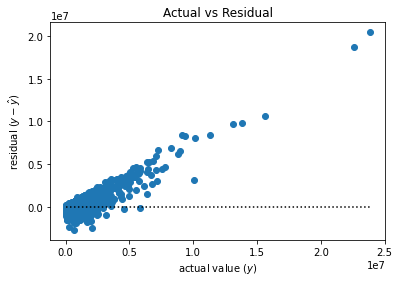

In [50]:
model.plot_residuals(ols_eval.actual, ols_eval.ols_yhat)

(array([1.000e+00, 3.000e+00, 6.000e+00, 2.300e+01, 5.800e+01, 2.240e+02,
        7.580e+02, 2.279e+03, 2.655e+03, 1.870e+02]),
 array([ 2.56175668,  3.78668763,  5.01161859,  6.23654954,  7.4614805 ,
         8.68641145,  9.91134241, 11.13627336, 12.36120432, 13.58613527,
        14.81106623]),
 <a list of 10 Patch objects>)

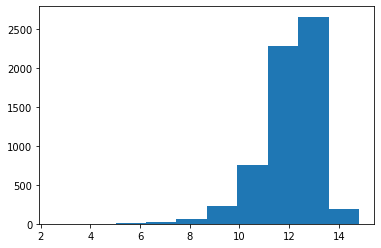

In [51]:
# create a histogram 
plt.hist(np.log(ols_eval.residuals))

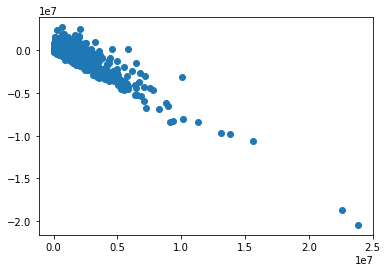

In [52]:
# create a scatter plot of the residuals and look for patters
plt.scatter(ols_eval.actual, ols_eval.residuals)

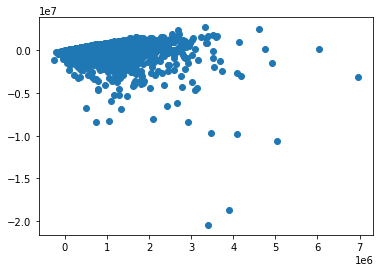

In [54]:
# look at predictions vs residuals
plt.scatter(ols_eval.ols_yhat, ols_eval.residuals)

In [55]:
df.head()

,bathrooms,bedrooms,square_feet,home_value
parcelid,,,,
11289917,2.0,3.0,1458.0,136104.0
11705026,1.0,2.0,1421.0,35606.0
14269464,3.0,4.0,2541.0,880456.0
11389003,2.0,3.0,1650.0,614000.0
11967869,1.0,2.0,693.0,274237.0


In [56]:
# Define X and y variables
X = df[['bathrooms', 'bedrooms', 'square_feet']]
y = df[['home_value']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=123)

In [57]:
X_train.head()

,bathrooms,bedrooms,square_feet
parcelid,,,
11713180,3.0,2.0,1736.0
10774370,3.0,3.0,1565.0
12279758,2.0,3.0,1334.0
14476387,2.0,2.0,1503.0
10719724,2.0,3.0,1372.0


In [58]:
# Initialize the Linear Regression Object 
lm = LinearRegression()

rfe = RFE(lm, 2)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)

In [59]:
# boolean mask for each variable of whether it was selected or not. 
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 2 features: bathrooms, bedrooms


In [60]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# Fitting the data to model
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-162720.02982986]
features:  Index(['bathrooms', 'bedrooms'], dtype='object')
coefficients:  [[424119.27275677 -84598.84315017]]


In [63]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

,home_value,yhat_lm
parcelid,,
11713180,446597.0,940440.1
10774370,364898.0,855841.3
12279758,254856.0,431722.0
14476387,228954.0,516320.8
10719724,62074.0,431722.0


In [64]:
# Evaluate RMSE
RMSE_lm = np.sqrt(mean_squared_error(y_train.home_value, y_train.yhat_lm))
RMSE_lm

print("linear model\n  Root mean squared error: {:.3}".format(RMSE_lm))

linear model
  Root mean squared error: 6.43e+05


In [84]:
r2_lm = lm.score(X_rfe, y_train.home_value)

print(f"{r2_lm:.2%} of the variance in the home's value can be explained by the difference in bedrooms and bathrooms.")

print("This means almost 73% of the variance in the home's value is due to other factors, such as square feet.")
print("Previous models have shown that square footage has the highest correlation to home value.")
      

27.04% of the variance in the home's value can be explained by the difference in bedrooms and bathrooms.
This means almost 73% of the variance in the home's value is due to other factors, such as square feet.
Previous models have shown that square footage has the highest correlation to home value.


In [66]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
print(output)

home_value = -1.627e+05 + 4.2e+05 * bathrooms + -8.46e+04 * bedrooms


# Poly Nomial Regression Model

In [67]:
# Poly Nomial Regression model

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [68]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.home_value)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [69]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.home_value, y_train.yhat_poly))
RMSE_poly

print("polynomial model\n  Root mean squared error: {:.3}".format(RMSE_poly))

polynomial model
  Root mean squared error: 6.13e+05


In [70]:
y_train.head()

,home_value,yhat_lm,yhat_poly
parcelid,,,
11713180,446597.0,940440.1,824031.5
10774370,364898.0,855841.3,704931.2
12279758,254856.0,431722.0,376100.7
14476387,228954.0,516320.8,439228.4
10719724,62074.0,431722.0,376100.7


In [71]:
# set predictions to be the mean of all final grades
y_train['yhat_baseline'] = df['home_value'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.home_value, y_train.yhat_baseline))
print("Baseline (ŷ = ȳ)\n  Root mean squared error: {:.3}".format(RMSE_bl)) 

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.home_value, y_train.yhat_baseline)
print('  {:.2%} of the variance.'.format(evs))

Baseline (ŷ = ȳ)
  Root mean squared error: 7.52e+05
  0.00% of the variance.


In [72]:
y_train.head()

,home_value,yhat_lm,yhat_poly,yhat_baseline
parcelid,,,,
11713180,446597.0,940440.1,824031.5,541332.7
10774370,364898.0,855841.3,704931.2,541332.7
12279758,254856.0,431722.0,376100.7,541332.7
14476387,228954.0,516320.8,439228.4,541332.7
10719724,62074.0,431722.0,376100.7,541332.7


Text(0.5, 1.0, 'Predicted vs Actual Home Value')

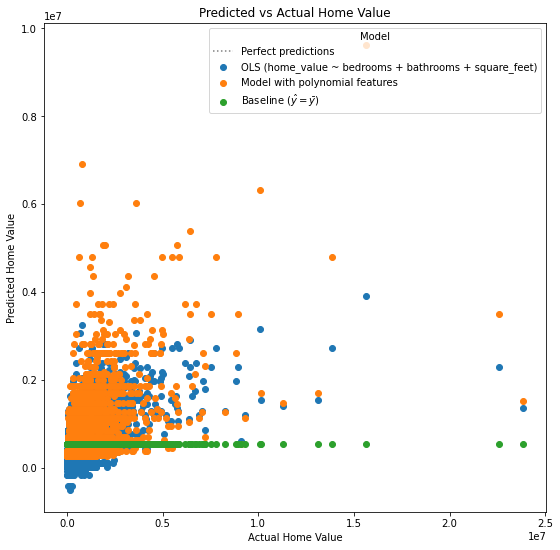

In [73]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.home_value, y_train.yhat_lm, label='OLS (home_value ~ bedrooms + bathrooms + square_feet)', marker='o')
plt.scatter(y_train.home_value, y_train.yhat_poly, label='Model with polynomial features', marker='o')
plt.scatter(y_train.home_value, y_train.yhat_baseline, label=r'Baseline ($\hat{y} = \bar{y}$)', marker='o')
plt.plot([60, 100], [60, 100], label='Perfect predictions', ls=':', c='grey')

plt.legend(title='Model')
plt.ylabel('Predicted Home Value')
plt.xlabel('Actual Home Value')
plt.title('Predicted vs Actual Home Value')